# **Part 1: Understanding where our datset comes from : Kaggle dataset load**

#### I will load my dataset from kaggle, join the 19 Dataframes and merge them.


In [13]:

import pandas as pd
import numpy as np
from functools import reduce
import os
import kagglehub
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:

# Download latest version
path = kagglehub.dataset_download("georgejdinicola/world-bank-indicators")

print("Path to dataset files:", path)

# Path to the downloaded dataset
csv_dir = pathlib.Path("/Users/Martagilant/.cache/kagglehub/datasets/georgejdinicola/world-bank-indicators/versions/7")

# Exclude helper files (optional)
EXCLUDE_FILES = {
    "world-bank-indicator-mapping.csv",
    "world_bank_indicators.csv"
}

# Load all CSVs
csv_paths = sorted(
    p for p in csv_dir.rglob("*.csv")
    if p.name not in EXCLUDE_FILES
)

dfs = []
for path in csv_paths:
    try:
        df = pd.read_csv(path, dtype={"year": "int64", "country": "string"})
        dfs.append(df)
        print(f"Loaded: {path.name}, shape: {df.shape}")
    except Exception as e:
        print(f"Failed to load {path.name}: {e}")

# This assumes `dfs` already contains the 19 loaded dataframes (do NOT redefine dfs = ...)

# Step 1: Check if dfs is valid
if not dfs or not all(isinstance(df, pd.DataFrame) for df in dfs):
    print("❌ ERROR: `dfs` is empty or invalid. Please load the CSVs first.")
else:
    # Step 2: Merge all on year + country
    def merge_dfs(left, right):
        return pd.merge(left, right, on=["year", "country"], how="outer")

    merged = reduce(merge_dfs, dfs)
    merged.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_cleaned = merged.dropna(axis=1, how='all').dropna(axis=0, how='all')

    # Step 3: Export to src/data_sample
    output_path = "src/data_sample/merged_world_bank_data.csv"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    merged_cleaned.to_csv(output_path, index=False)
    print(f"✅ Merged CSV saved to: {output_path}")



## For GDP growth predictions there are some fundamental economic drivers:

Most Important Features:

- Lagged GDP growth - Past growth strongly predicts future growth

- Investment rate (Gross fixed capital formation % of GDP) - Key growth driver

- Savings rate - Funds future investment

- Trade balance - External sector health

- Inflation - Macroeconomic stability indicator

### This merged model has 803 columns and ~ 17000 rows, because of this I have decided to, before I even begin my analysis, to get rid of some DataFrames and columns, to allow for a more efficient and faster model. 

### Some columns I decided to get rid of were due to:

🚫 Data Leakage - Some growth rates might not be available when making real predictions

🔄 Circular Logic - GDP components that are essentially the same as your target variable

📊 Scale Issues - Absolute values vary dramatically by country size; ratios are more meaningful

🔍 Too Granular - Individual aid flows add noise without predictive power

📈 Multicollinearity - Many GDP-related variables are highly correlated

### The golden rule: If a variable is basically another way of measuring GDP or requires knowing GDP to calculate it, I will exclude it.
I will keep:

Ratios and percentages (% of GDP, % of population)

Growth rates (but not future ones)

Structural indicators (education, infrastructure)

Policy variables (investment rates, trade openness)

Lagged versions of your target variable


###  * Information can be found here: https://datatopics.worldbank.org/world-development-indicators/themes/economy.html#:~:text=Economic%20indicators%20include%20measures%20of%20macroeconomic%20performance,money%20supply%2C%20and%20the%20balance%20of%20payments).&text=Many%20WDI%20indicators%20use%20GDP%20or%20GDP,cross%2Dcountry%20comparisons%20of%20socioeconomic%20and%20other%20data.




In [ ]:
import pandas as pd
import numpy as np

# Complete list of columns to exclude from GDP growth model
columns_to_exclude = [
    # Future-looking data (Data Leakage Risk)
    "Adjusted net national income (annual % growth)",
    "Final consumption expenditure (annual % growth)", 
    "Gross capital formation (annual % growth)",
    "Households and NPISHs Final consumption expenditure (annual % growth)",
    
    # GDP-related variables (Circular Logic)
    "GDP (current US$)",
    "GDP (constant 2015 US$)", 
    "GDP, PPP (current international $)",
    "GDP, PPP (constant 2021 international $)",
    "GDP per capita (current US$)",
    "GDP per capita, PPP (current international $)",
    "GDP per capita, PPP (constant 2021 international $)",
    "GNI (current US$)",
    "GNI (constant 2015 US$)",
    "GNI, PPP (current international $)", 
    "GNI, PPP (constant 2021 international $)",
    "GNI per capita (current US$)",
    "GNI per capita, PPP (current international $)",
    "GNI per capita, PPP (constant 2021 international $)",
    "GNI, Atlas method (current US$)",
    "GNI per capita, Atlas method (current US$)",
    "Gross value added at basic prices (GVA) (current US$)",
    "Gross value added at basic prices (GVA) (constant 2015 US$)",
    "Final consumption expenditure (current US$)",
    "Final consumption expenditure (constant 2015 US$)",
    "Gross national expenditure (current US$)",
    "Gross national expenditure (constant 2015 US$)",
    
    # Absolute values (prefer ratios/percentages)
    "Population, total",
    "Rural population",
    "General government final consumption expenditure (current US$)",
    "General government final consumption expenditure (constant 2015 US$)",
    "Households and NPISHs Final consumption expenditure (current US$)",
    "Households and NPISHs Final consumption expenditure (constant 2015 US$)",
    "Households and NPISHs Final consumption expenditure, PPP (current international $)",
    "Households and NPISHs Final consumption expenditure, PPP (constant 2021 international $)",
    "Gross fixed capital formation (current US$)",
    "Gross fixed capital formation (constant 2015 US$)",
    "Gross capital formation (current US$)",
    "Gross capital formation (constant 2015 US$)",
    "Gross domestic savings (current US$)",
    "Agriculture, forestry, and fishing, value added (current US$)",
    "Agriculture, forestry, and fishing, value added (constant 2015 US$)",
    "Manufacturing, value added (current US$)",
    "Industry (including construction), value added (current US$)",
    "Industry (including construction), value added (constant 2015 US$)",
    "Services, value added (current US$)",
    "Services, value added (constant 2015 US$)",
    "Agricultural land (sq. km)",
    "Forest area (sq. km)",
    "Land under cereal production (hectares)",
    
    # Detailed aid flows (too granular)
    "Net bilateral aid flows from DAC donors, Australia (current US$)",
    "Net bilateral aid flows from DAC donors, Austria (current US$)",
    "Net bilateral aid flows from DAC donors, Belgium (current US$)",
    "Net bilateral aid flows from DAC donors, Canada (current US$)",
    "Net bilateral aid flows from DAC donors, European Union institutions (current US$)",
    "Net bilateral aid flows from DAC donors, Switzerland (current US$)",
    "Net bilateral aid flows from DAC donors, Czechia (current US$)",
    "Net bilateral aid flows from DAC donors, Germany (current US$)",
    "Net bilateral aid flows from DAC donors, Denmark (current US$)",
    "Net bilateral aid flows from DAC donors, Spain (current US$)",
    "Net bilateral aid flows from DAC donors, Finland (current US$)",
    "Net bilateral aid flows from DAC donors, France (current US$)",
    "Net bilateral aid flows from DAC donors, United Kingdom (current US$)",
    "Net bilateral aid flows from DAC donors, Greece (current US$)",
    "Net bilateral aid flows from DAC donors, Hungary (current US$)",
    "Net bilateral aid flows from DAC donors, Ireland (current US$)",
    "Net bilateral aid flows from DAC donors, Iceland (current US$)",
    "Net bilateral aid flows from DAC donors, Italy (current US$)",
    "Net bilateral aid flows from DAC donors, Japan (current US$)",
    "Net bilateral aid flows from DAC donors, Korea, Rep. (current US$)",
    "Net bilateral aid flows from DAC donors, Luxembourg (current US$)",
    "Net bilateral aid flows from DAC donors, Netherlands (current US$)",
    "Net bilateral aid flows from DAC donors, Norway (current US$)",
    "Net bilateral aid flows from DAC donors, New Zealand (current US$)",
    "Net bilateral aid flows from DAC donors, Poland (current US$)",
    "Net bilateral aid flows from DAC donors, Portugal (current US$)",
    "Net bilateral aid flows from DAC donors, Slovak Republic (current US$)",
    "Net bilateral aid flows from DAC donors, Slovenia (current US$)",
    "Net bilateral aid flows from DAC donors, Sweden (current US$)",
    "Net bilateral aid flows from DAC donors, United States (current US$)",
    
    # UN agency flows
    "Net official flows from UN agencies, FAO (current US$)",
    "Net official flows from UN agencies, IAEA (current US$)",
    "Net official flows from UN agencies, IFAD (current US$)",
    "Net official flows from UN agencies, ILO (current US$)",
    "Net official flows from UN agencies, UNAIDS (current US$)",
    "Net official flows from UN agencies, UNICEF (current US$)",
    "Net official flows from UN agencies, UNHCR (current US$)",
    "Net official flows from UN agencies, UNDP (current US$)",
    "Net official flows from UN agencies, UNECE (current US$)",
    "Net official flows from UN agencies, UNEP (current US$)",
    "Net official flows from UN agencies, UNFPA (current US$)",
    "Net official flows from UN agencies, UNPBF (current US$)",
    "Net official flows from UN agencies, UNRWA (current US$)",
    "Net official flows from UN agencies, UNTA (current US$)",
    "Net official flows from UN agencies, UNWTO (current US$)",
    "Net official flows from UN agencies, WFP (current US$)",
    "Net official flows from UN agencies, WHO (current US$)",
    
    # Detailed education metrics
    "Trained teachers in preprimary education, female (% of female teachers)",
    "Trained teachers in preprimary education, male (% of male teachers)",
    "Trained teachers in primary education, male (% of male teachers)",
    "Trained teachers in secondary education, female (% of female teachers)",
    "Trained teachers in lower secondary education, female (% of female teachers)",
    "Trained teachers in lower secondary education, male (% of male teachers)",
    "Trained teachers in upper secondary education, female (% of female teachers)",
    "Trained teachers in upper secondary education, male (% of male teachers)",
    "Primary education, pupils",
    "Secondary education, pupils", 
    "Primary education, teachers",
    "Secondary education, teachers",
    
    # Balance of payments details
    "Communications, computer, etc. (% of service imports, BoP)",
    "Primary income payments (BoP, current US$)",
    "Service imports (BoP, current US$)",
    "Transport services (% of service imports, BoP)",
    "Secondary income, other sectors, payments (BoP, current US$)",
    "ICT service exports (% of service exports, BoP)",
    "Primary income receipts (BoP, current US$)",
    "Transport services (% of service exports, BoP)",
    "Secondary income receipts (BoP, current US$)",
]

# Function to clean dataset for GDP growth modeling
def clean_dataset_for_gdp_model(df, verbose=True):
    """
    Remove columns that should be excluded from GDP growth prediction model
    
    Parameters:
    df: pandas DataFrame - your merged dataset
    verbose: bool - whether to print progress information
    
    Returns:
    pandas DataFrame - cleaned dataset
    """
    
    if verbose:
        print("=== CLEANING DATASET FOR GDP GROWTH MODEL ===")
        print(f"Original dataset shape: {df.shape}")
    
    # Check which excluded columns actually exist in the dataset
    existing_exclusions = [col for col in columns_to_exclude if col in df.columns]
    missing_exclusions = [col for col in columns_to_exclude if col not in df.columns]
    
    if verbose:
        print(f"\nColumns to exclude that exist in dataset: {len(existing_exclusions)}")
        print(f"Columns to exclude that don't exist: {len(missing_exclusions)}")
        
        if missing_exclusions[:5]:  # Show first 5 missing ones
            print(f"Examples of missing columns: {missing_exclusions[:5]}")
    
    # Remove the columns
    cleaned_df = df.drop(columns=existing_exclusions)
    
    if verbose:
        print(f"\nAfter removing excluded columns: {cleaned_df.shape}")
        print(f"Removed {len(existing_exclusions)} columns")
        print(f"Remaining {cleaned_df.shape[1]} columns")
        
        # Show remaining column types
        remaining_cols = list(cleaned_df.columns)
        print(f"\nRemaining columns include:")
        print(f"  - Core identifiers: year, country")
        print(f"  - Target variable: GDP growth (annual %)")
        print(f"  - Economic ratios and percentages")
        print(f"  - Growth rates and structural indicators")
    
    return cleaned_df

# Apply the cleaning to your merged dataset
# Assuming your merged dataset is called 'merged_cleaned'
gdp_model_data = clean_dataset_for_gdp_model(merged_cleaned)

# Optional: Focus on most important features for initial modeling
key_features_for_modeling = [
    'year', 
    'country', 
    'GDP growth (annual %)',  # Target variable
    
    # Core economic indicators
    'GDP per capita (constant 2015 US$)',
    'Gross fixed capital formation (% of GDP)',
    'Gross domestic savings (% of GDP)', 
    'Inflation, GDP deflator (annual %)',
    
    # Trade and external
    'Exports of goods and services (% of GDP)',
    'Imports of goods and services (% of GDP)',
    'Foreign direct investment, net inflows (% of GDP)',
    
    # Structural factors
    'Population growth (annual %)',
    'Industry (including construction), value added (% of GDP)',
    'Agriculture, forestry, and fishing, value added (% of GDP)',
    'Services, value added (% of GDP)',
    
    # Human capital
    'School enrollment, secondary (% gross)',
    'Literacy rate, adult total (% of people ages 15 and above)',
    
    # Infrastructure
    'Access to electricity, rural (% of rural population)',
]

# Create focused dataset with key features only
print("\n" + "="*50)
print("CREATING FOCUSED DATASET FOR INITIAL MODELING")
print("="*50)

# Check which key features exist
existing_key_features = [col for col in key_features_for_modeling if col in gdp_model_data.columns]
missing_key_features = [col for col in key_features_for_modeling if col not in gdp_model_data.columns]

print(f"Key features available: {len(existing_key_features)}")
if missing_key_features:
    print(f"Missing key features: {missing_key_features}")

# Create focused dataset
focused_gdp_data = gdp_model_data[existing_key_features].copy()

print(f"Focused dataset shape: {focused_gdp_data.shape}")
print(f"Focused dataset columns: {list(focused_gdp_data.columns)}")

# Check data completeness
print(f"\nData completeness:")
completeness = (focused_gdp_data.notna().sum() / len(focused_gdp_data) * 100).round(1)
for col, pct in completeness.items():
    print(f"  {col}: {pct}%")

# Save the cleaned datasets
print(f"\nSaving cleaned datasets...")
gdp_model_data.to_csv("src/data_sample/gdp_model_full_cleaned.csv", index=False)
focused_gdp_data.to_csv("src/data_sample/gdp_model_focused.csv", index=False)
print(f"✅ Saved cleaned datasets to src/data_sample/")

In [3]:
#For now I will import the already merged dataset:
df = pd.read_csv("src/data_sample/gdp_model_focused.csv")


# **Part 2 : Understanding our business problem**

Because we are assuming that this is a GDP growth estimation by country, this is a Supervised Learning Regression problem.

(*Refer to **img** folder for a graph on Machine Learning problems*)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16900 entries, 0 to 16899
Data columns (total 17 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   year                                                        16900 non-null  int64  
 1   country                                                     16900 non-null  object 
 2   GDP growth (annual %)                                       13575 non-null  float64
 3   GDP per capita (constant 2015 US$)                          13695 non-null  float64
 4   Gross fixed capital formation (% of GDP)                    9793 non-null   float64
 5   Gross domestic savings (% of GDP)                           10497 non-null  float64
 6   Inflation, GDP deflator (annual %)                          13470 non-null  float64
 7   Exports of goods and services (% of GDP)                    10802 non-null  float64
 

In [6]:
df.columns

Index(['year', 'country', 'GDP growth (annual %)',
       'GDP per capita (constant 2015 US$)',
       'Gross fixed capital formation (% of GDP)',
       'Gross domestic savings (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Exports of goods and services (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Foreign direct investment, net inflows (% of GDP)',
       'Population growth (annual %)',
       'Industry (including construction), value added (% of GDP)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Services, value added (% of GDP)',
       'School enrollment, secondary (% gross)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'Access to electricity, rural (% of rural population)'],
      dtype='object')

In [7]:
df["GDP growth (annual %)"].value_counts()

GDP growth (annual %)
 0.000000     15
 3.761612      2
 0.619467      2
 4.286275      2
 11.647093     2
              ..
-0.236337      1
 3.772402      1
 6.054514      1
 10.399009     1
 5.336730      1
Name: count, Length: 13434, dtype: int64

Interesting , there seems to be a wide range across the countries in terms of GDP growth annually

In [8]:
df.head()

,year,country,GDP growth (annual %),GDP per capita (constant 2015 US$),Gross fixed capital formation (% of GDP),Gross domestic savings (% of GDP),"Inflation, GDP deflator (annual %)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Population growth (annual %),"Industry (including construction), value added (% of GDP)","Agriculture, forestry, and fishing, value added (% of GDP)","Services, value added (% of GDP)","School enrollment, secondary (% gross)","Literacy rate, adult total (% of people ages 15 and above)","Access to electricity, rural (% of rural population)"
0,1960,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960,AFE,NaN,1172.316285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960,AFW,NaN,1110.513849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lots of **NaNs** that we will have to deal with later

In [9]:
df.value_counts()

year  country  GDP growth (annual %)  GDP per capita (constant 2015 US$)  Gross fixed capital formation (% of GDP)  Gross domestic savings (% of GDP)  Inflation, GDP deflator (annual %)  Exports of goods and services (% of GDP)  Imports of goods and services (% of GDP)  Foreign direct investment, net inflows (% of GDP)  Population growth (annual %)  Industry (including construction), value added (% of GDP)  Agriculture, forestry, and fishing, value added (% of GDP)  Services, value added (% of GDP)  School enrollment, secondary (% gross)  Literacy rate, adult total (% of people ages 15 and above)  Access to electricity, rural (% of rural population)
1990  MUS      7.186737               3810.480833                         30.176859                                  24.034973                         10.583631                           64.093928                                 71.196573                                 1.526106                                           0.712313            

# **Part 3: Analyzing Target**

#### Let´s look at target distributions through different plots

In [ ]:
target = "GDP growth (annual %)"

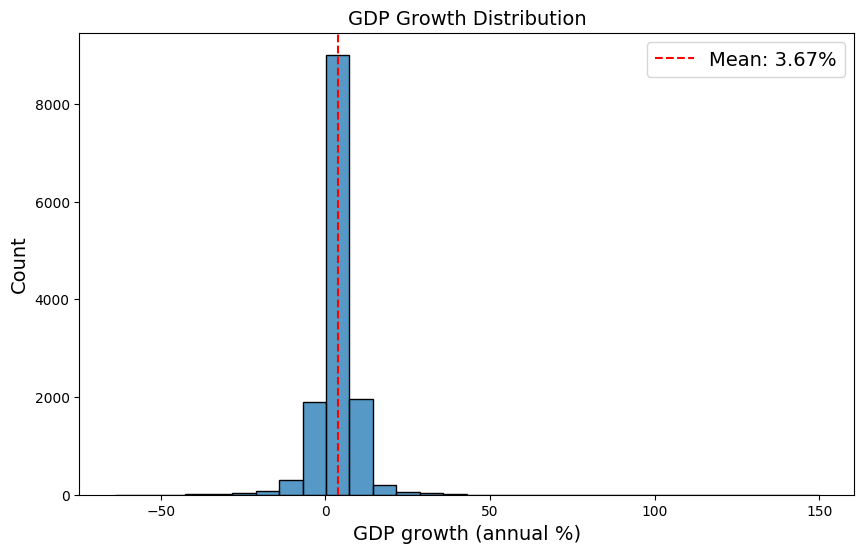

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="GDP growth (annual %)", bins=30)
plt.title('GDP Growth Distribution')
plt.axvline(df["GDP growth (annual %)"].mean(), color='red', linestyle='--', label=f'Mean: {df["GDP growth (annual %)"].mean():.2f}%')
plt.legend()
plt.show()

Good distribution of target, almost normal distribution, if slightly skewed to the right.

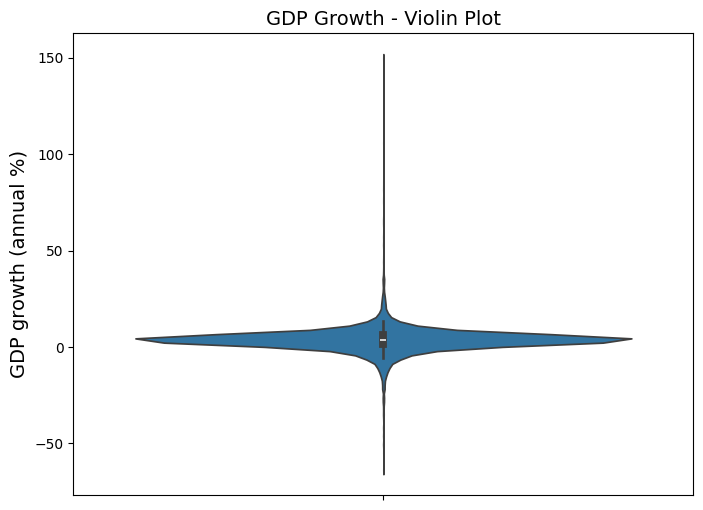

In [15]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, y="GDP growth (annual %)")
plt.title('GDP Growth - Violin Plot')
plt.show();

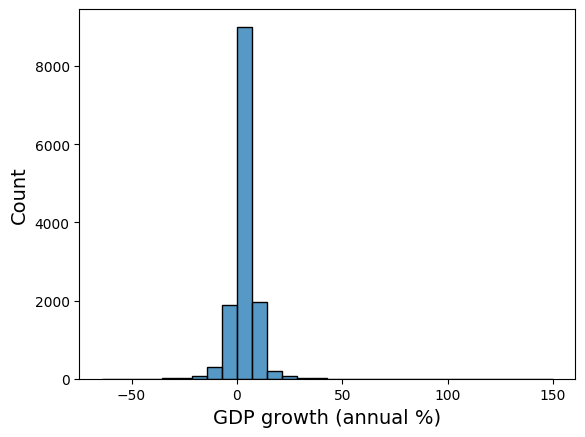

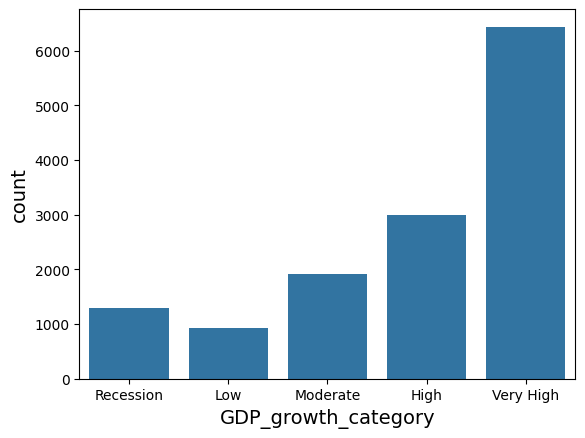

In [16]:

sns.histplot(data=df, x="GDP growth (annual %)", bins=30)
plt.show()

# Or if you want to bin the continuous values into categories first:
df['GDP_growth_category'] = pd.cut(df["GDP growth (annual %)"], 
                                  bins=[-float('inf'), -2, 0, 2, 4, float('inf')], 
                                  labels=['Recession', 'Low', 'Moderate', 'High', 'Very High'])
sns.countplot(data=df, x='GDP_growth_category')
plt.show()

##### We can see from here how theres a skew towards "Very High" GDP growth, followed by "High" and "Moderate", our dataset is imbalanced.

In [17]:
print("GDP Growth - Descriptive Statistics:")
print(df["GDP growth (annual %)"].describe())
print(f"\nSkewness: {df['GDP growth (annual %)'].skew():.3f}")
print(f"Kurtosis: {df['GDP growth (annual %)'].kurtosis():.3f}")

GDP Growth - Descriptive Statistics:
count    13575.000000
mean         3.669586
std          6.230779
min        -64.047107
25%          1.373394
50%          3.807604
75%          6.152008
max        149.972963
Name: GDP growth (annual %), dtype: float64

Skewness: 1.835
Kurtosis: 49.315


### Let´s fully look at all the plots:

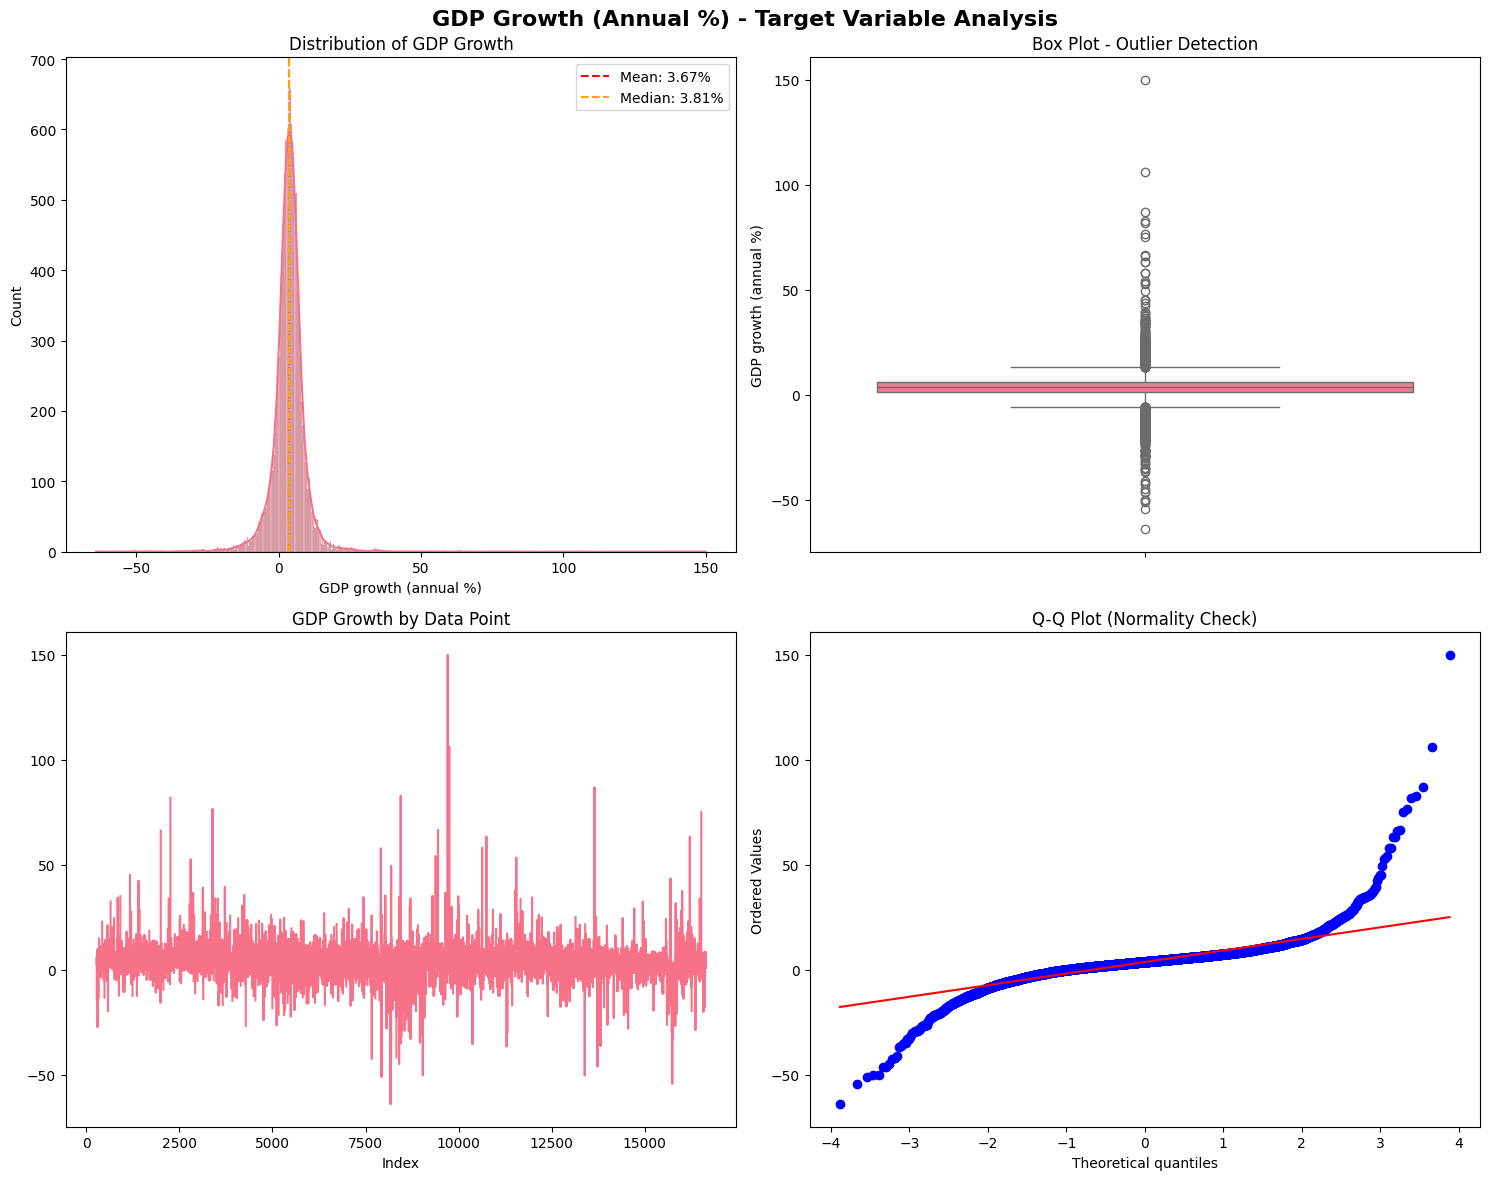

In [18]:
# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('GDP Growth (Annual %) - Target Variable Analysis', fontsize=16, fontweight='bold')

# 1. Distribution plot (histogram + KDE)
sns.histplot(data=df, x="GDP growth (annual %)", kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of GDP Growth')
axes[0,0].axvline(df["GDP growth (annual %)"].mean(), color='red', linestyle='--', label=f'Mean: {df["GDP growth (annual %)"].mean():.2f}%')
axes[0,0].axvline(df["GDP growth (annual %)"].median(), color='orange', linestyle='--', label=f'Median: {df["GDP growth (annual %)"].median():.2f}%')
axes[0,0].legend()

# 2. Box plot to see outliers
sns.boxplot(data=df, y="GDP growth (annual %)", ax=axes[0,1])
axes[0,1].set_title('Box Plot - Outlier Detection')

# 3. Time series plot (if you have a time/date column)
# Replace 'Year' with your actual time column name
if 'Year' in df.columns:
    sns.lineplot(data=df, x="Year", y="GDP growth (annual %)", ax=axes[1,0])
    axes[1,0].set_title('GDP Growth Over Time')
    axes[1,0].tick_params(axis='x', rotation=45)
else:
    # If no time column, show a simple line plot by index
    axes[1,0].plot(df.index, df["GDP growth (annual %)"])
    axes[1,0].set_title('GDP Growth by Data Point')
    axes[1,0].set_xlabel('Index')

# 4. Q-Q plot to check normality
from scipy import stats
stats.probplot(df["GDP growth (annual %)"].dropna(), dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.show()

### Things to note:

Top left plot:


- The distribution is fairly symmetrical, but the small difference between mean and median suggests slight left skewness.

- Extreme outliers are evident (e.g., values beyond ±50%), likely due to crisis or recovery years in specific countries.

Top right plot:

- Shows a tight interquartile range (IQR), but a large number of extreme outliers on both tails (especially positive).

- Outliers go up to 150% GDP growth and down to −50%, which are very unusual economic conditions.

Bottom left plot:

- Shows volatile data  across observations.ç

- Frequent spikes suggest that we have highly variable countries or years — a mix of stable and unstable economies.

Bottom right plot:

- The blue dots deviate heavily from the red diagonal line, especially in the tails, this indicates non-normality of GDP growth.


- The S-shaped curve means:

    - Left tail is heavier than normal (more extreme negative GDPs).
    
    - Right tail is also heavy, showing rare booms
